# A detailed look into dissipation

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u

import richio
richio.plots.use_nice_style()

In [2]:
beta = 1
mstar = .5 * richio.units.mscale
rstar = .47 * richio.units.lscale
mbh = 10**4 * richio.units.mscale
rt = rstar * (mbh/mstar)**(1/3)

ra = rt**2 / rstar #2 * Rt * (Mbh/mstar)**(1/3)

nozzle_box = u.unyt_array([-3*rt, -3*rt, -2*rt, 3*rt, 3*rt, 2*rt])
big_box = u.unyt_array([-6*ra, -4*ra, -2*ra, 2.5*ra, 3*ra, 2*ra])
mid_box = u.unyt_array([-3*ra, -2*ra, -0.8*ra, 2*ra, 2*ra, 0.8*ra])

In [3]:
path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_21'
path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_76'
path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_118'

snap = richio.load(path)
print(snap.keys())
snap.tfb

['CMx', 'CMy', 'CMz', 'Den', 'Diss', 'Entropy', 'IE', 'Mass', 'P', 'Rad', 'Star', 'T', 'Vol', 'Vx', 'Vy', 'Vz', 'box', 'tfb']


unyt_quantity(4.35892813, 'day')

## Plot

### Projection

In [ ]:
projected_data, xspace, yspace = snap.project(
    data=snap.dissipation, 
    x='CMx', 
    y='CMy', 
    z='CMz', 
    res=(512, 512, 512),
    box_size=mid_box
    )

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


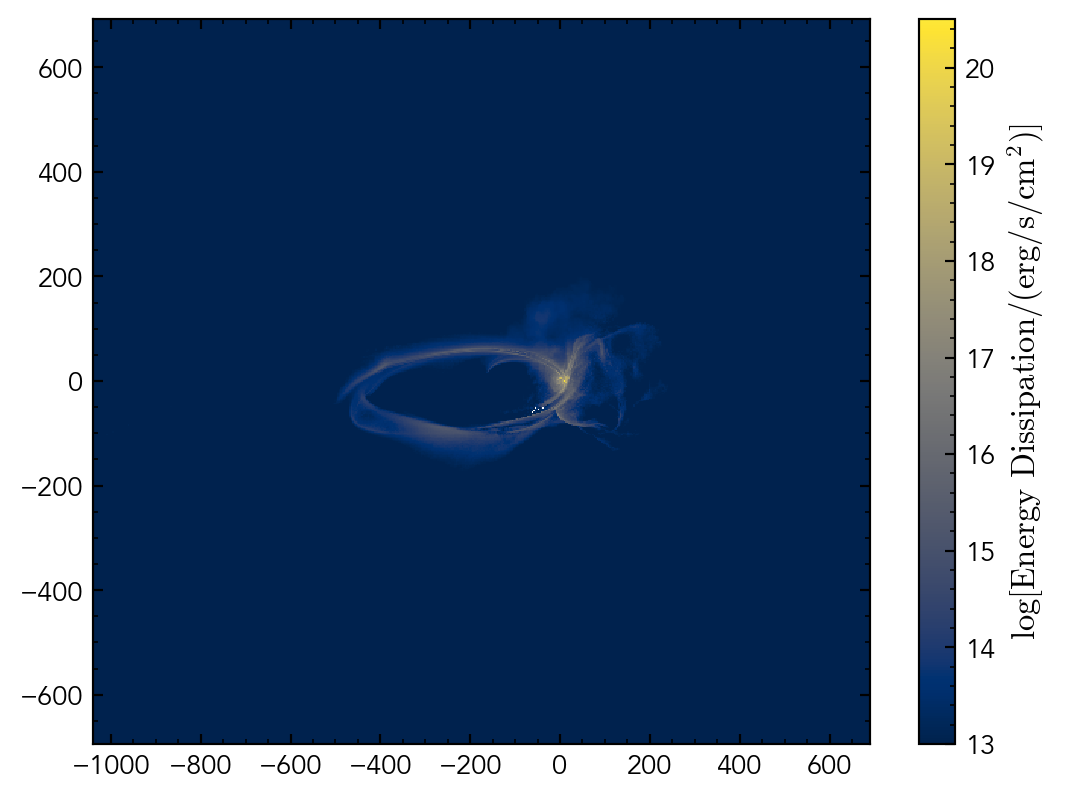

In [6]:
ax, im = richio.plots.scalar_map(
    f=projected_data,
    xspace=xspace,
    yspace=yspace,
    cmap='cividis',
    label_latex=r'\text{Energy Dissipation}',
    unit_latex=r'\mathrm{(erg/s/cm^2)}',
    vmin=13
)
# plt.xlim(-600, 400)
# plt.ylim(-500, 500)
plt.show()

### Slice

In [6]:
sliced_data, xspace, yspace = snap.slice(
    data=snap.dissipation, 
    x='CMx', 
    y='CMy', 
    z='CMz', 
    res=(512, 512),
    box_size=mid_box,
    slice_coord=0,
    )

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


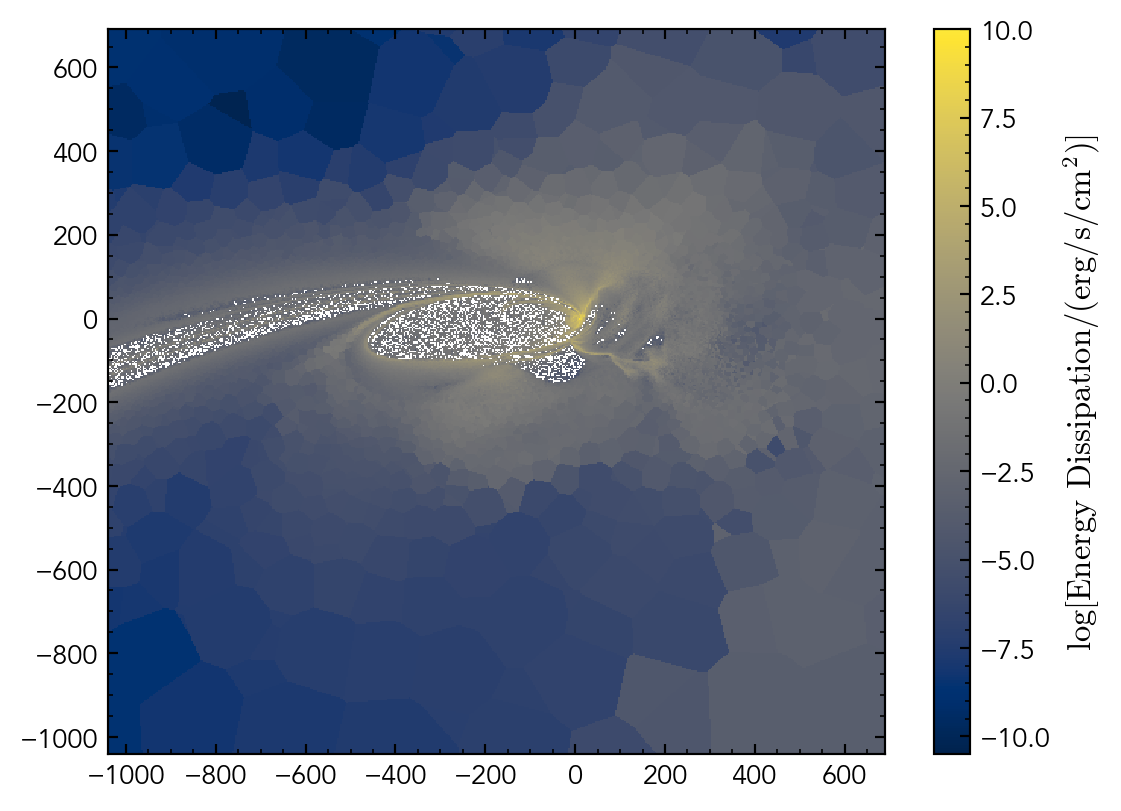

In [7]:
ax, im = richio.plots.scalar_map(
    f=sliced_data,
    xspace=xspace,
    yspace=yspace,
    cmap='cividis',
    label_latex=r'\text{Energy Dissipation}',
    unit_latex=r'\mathrm{(erg/s/cm^2)}',
    # vmin=0
)
# plt.xlim(-600, 400)
# plt.ylim(-500, 500)
plt.show()

## Negative dissipation?

### Is it related to floor gases?

In [7]:
diss = snap.dissipation

In [8]:
n_negative_disspation = np.sum(diss < 0)
n_total = len(snap)
print(f"Number of negative dissipation cells vs all: {n_negative_disspation}/{n_total}")
print(f"Rate {n_negative_disspation/n_total}")

Number of negative dissipation cells vs all: 14166379/66032092
Rate 0.2145377886861437


In [9]:
n_floor = np.sum(~snap.mask_star_ratio())
print(f"Number of floor gas cells vs all: {n_floor} / {n_total}")
print(f"Rate {n_floor/n_total}")

Number of floor gas cells vs all: 182909 / 66032092
Rate 0.0027700015925589635


In [10]:
diss = snap.dissipation[snap.mask_star_ratio()]
n_negative_disspation = np.sum(diss < 0)
n_no_floor = len(snap)
print("After removing floor gases,")
print(f"Number of negative dissipation cells vs all: {n_negative_disspation}/{n_no_floor}")
print(f"Rate {n_negative_disspation/n_no_floor}")

After removing floor gases,
Number of negative dissipation cells vs all: 14164372/66032092
Rate 0.21450739437423852


### Round-off error?

In [15]:
diss = snap.dissipation
diss_negative = diss[diss < 0]

In [16]:
print("Max and min of the negative dissipation cells")
print(np.min(diss_negative), np.min(diss_negative).in_cgs())
print(np.max(diss_negative), np.max(diss_negative).in_cgs())

Max and min of the negative dissipation cells
-6.322314653232292e-09 code_mass/(code_length*code_time**3) -43853.82658375759 g/(cm*s**3)
-7.720636206036548e-35 code_mass/(code_length*code_time**3) -5.355308298721066e-22 g/(cm*s**3)


In [17]:
diss_positive = diss[diss >= 0]

print("Max and min of the positive dissipation cells")
print(np.min(diss_positive), np.min(diss_positive).in_cgs())
print(np.max(diss_positive), np.max(diss_positive).in_cgs())

Max and min of the positive dissipation cells
1.4431808112909627e-34 code_mass/(code_length*code_time**3) 1.0010416200181349e-21 g/(cm*s**3)
0.002543168590696238 code_mass/(code_length*code_time**3) 17640323278.221107 g/(cm*s**3)


### Correlation with density/temperature/...?

In [8]:
diss = snap.dissipation.in_cgs()
star_mask = snap.mask_star_ratio()
diss = diss[star_mask]

mask = diss < 0
diss_negative = diss[mask]  # 

In [9]:
snap.keys()

['CMx',
 'CMy',
 'CMz',
 'Den',
 'Diss',
 'Entropy',
 'IE',
 'Mass',
 'P',
 'Rad',
 'Star',
 'T',
 'Vol',
 'Vx',
 'Vy',
 'Vz',
 'box',
 'tfb']

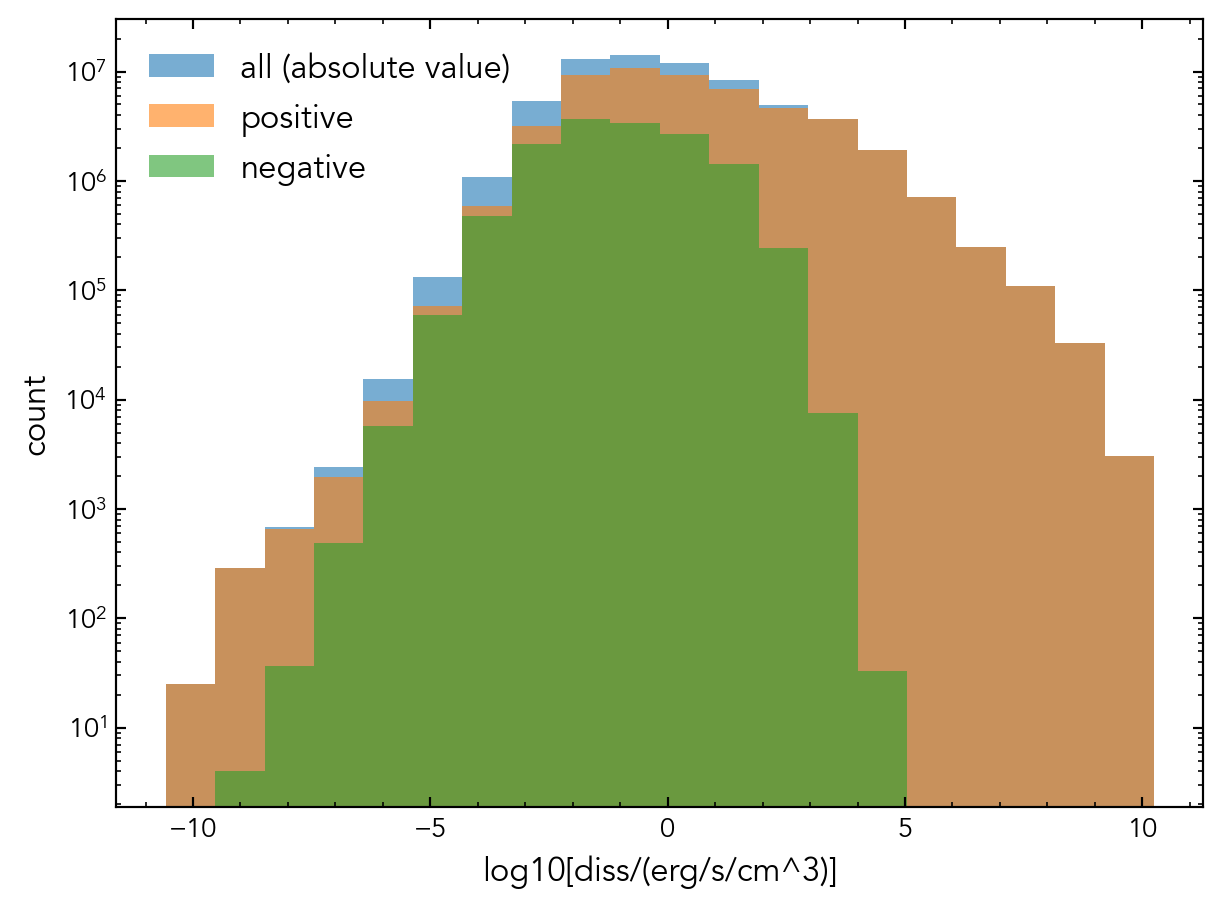

In [82]:
a_all = np.log10(np.abs(diss))
a_sub = np.log10(diss[~mask])
a_neg = np.log10(-diss_negative)

combined = np.concatenate([a_all, a_sub, a_neg])

bins = np.histogram_bin_edges(combined, bins=20)

plt.hist(a_all, bins=bins, alpha=0.6, label='all (absolute value)')
plt.hist(a_sub, bins=bins, alpha=0.6, label='positive')
plt.hist(a_neg, bins=bins, alpha=0.6, label='negative')

plt.yscale('log')
plt.xlabel('log10[diss/(erg/s/cm^3)]')
plt.ylabel('count')
plt.legend()
plt.tight_layout()

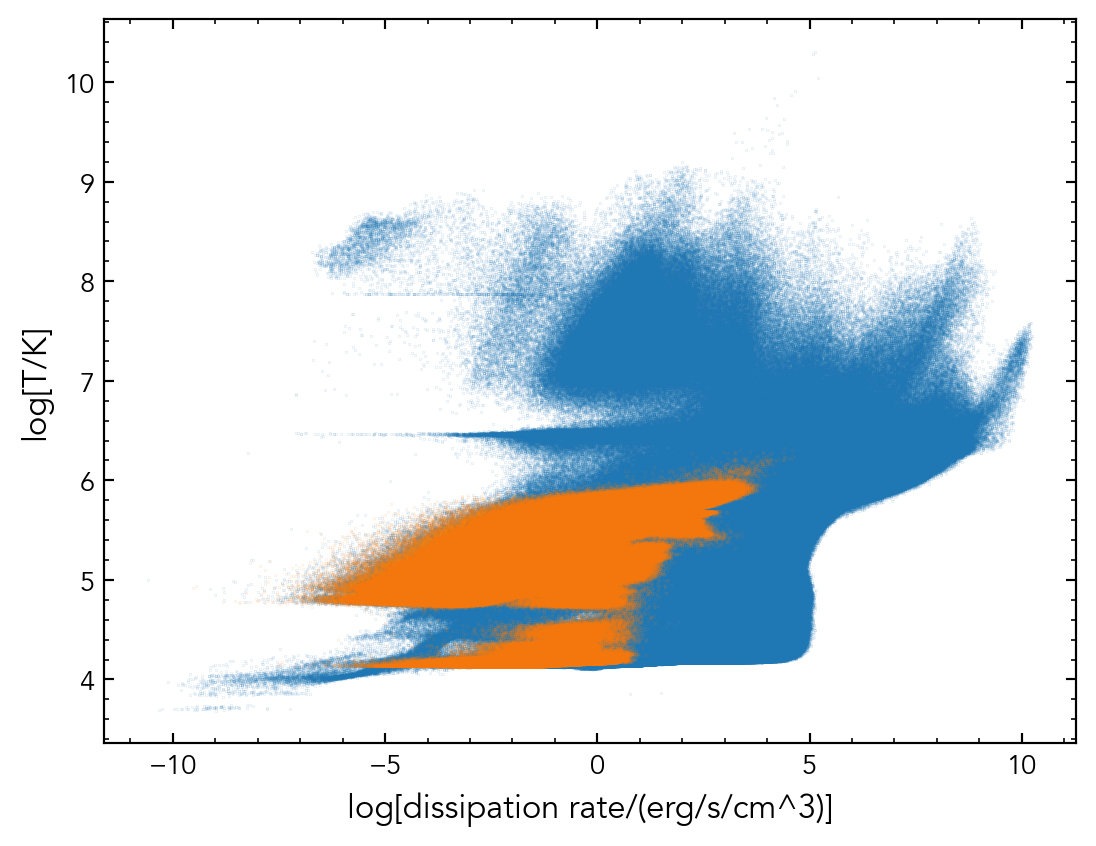

In [13]:
plt.scatter(np.log10(diss[~mask]), np.log10(snap.temperature[star_mask][~mask]), s=0.001)
plt.scatter(np.log10(-diss_negative), np.log10(snap.temperature[star_mask][mask]), s=0.001)
plt.xlabel('log[dissipation rate/(erg/s/cm^3)]')
plt.ylabel('log[T/K]')
plt.show()

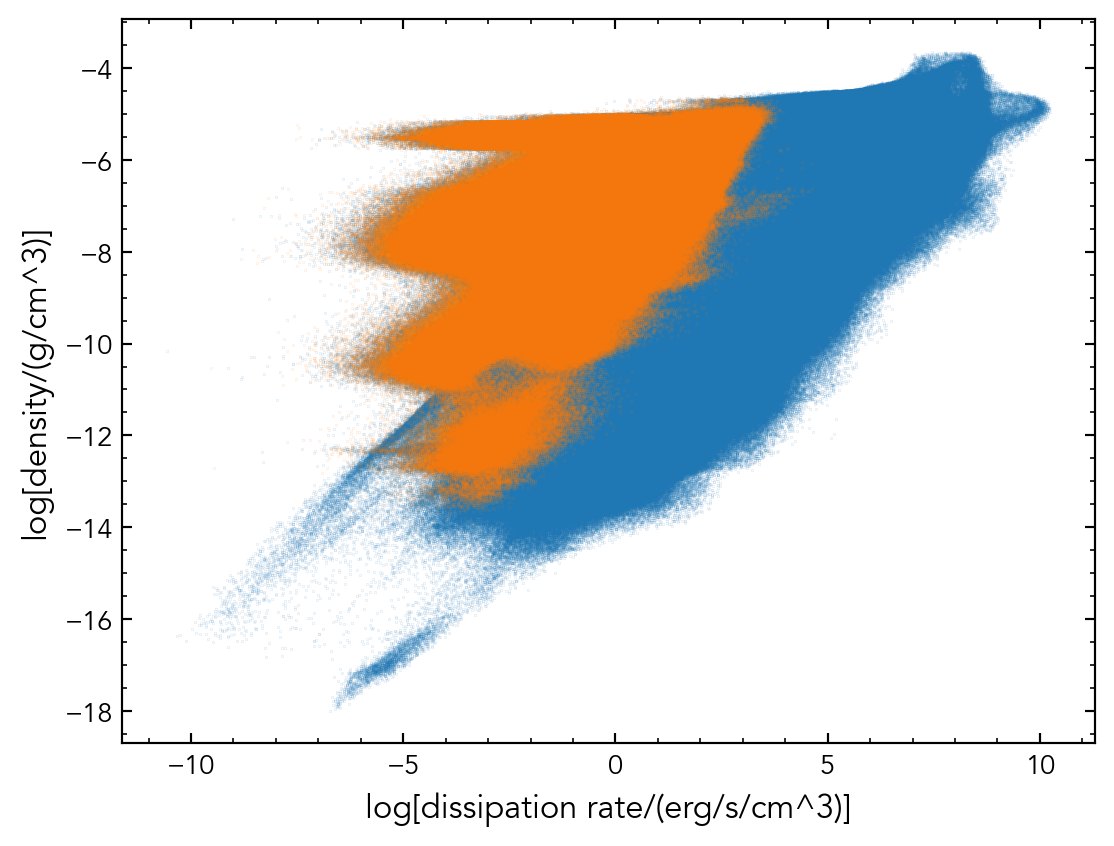

In [14]:
plt.scatter(np.log10(diss[~mask]), np.log10(snap.density[star_mask][~mask].in_cgs()), s=0.001)
plt.scatter(np.log10(-diss_negative), np.log10(snap.density[star_mask][mask].in_cgs()), s=0.001)
plt.xlabel('log[dissipation rate/(erg/s/cm^3)]')
plt.ylabel('log[density/(g/cm^3)]')
plt.show()

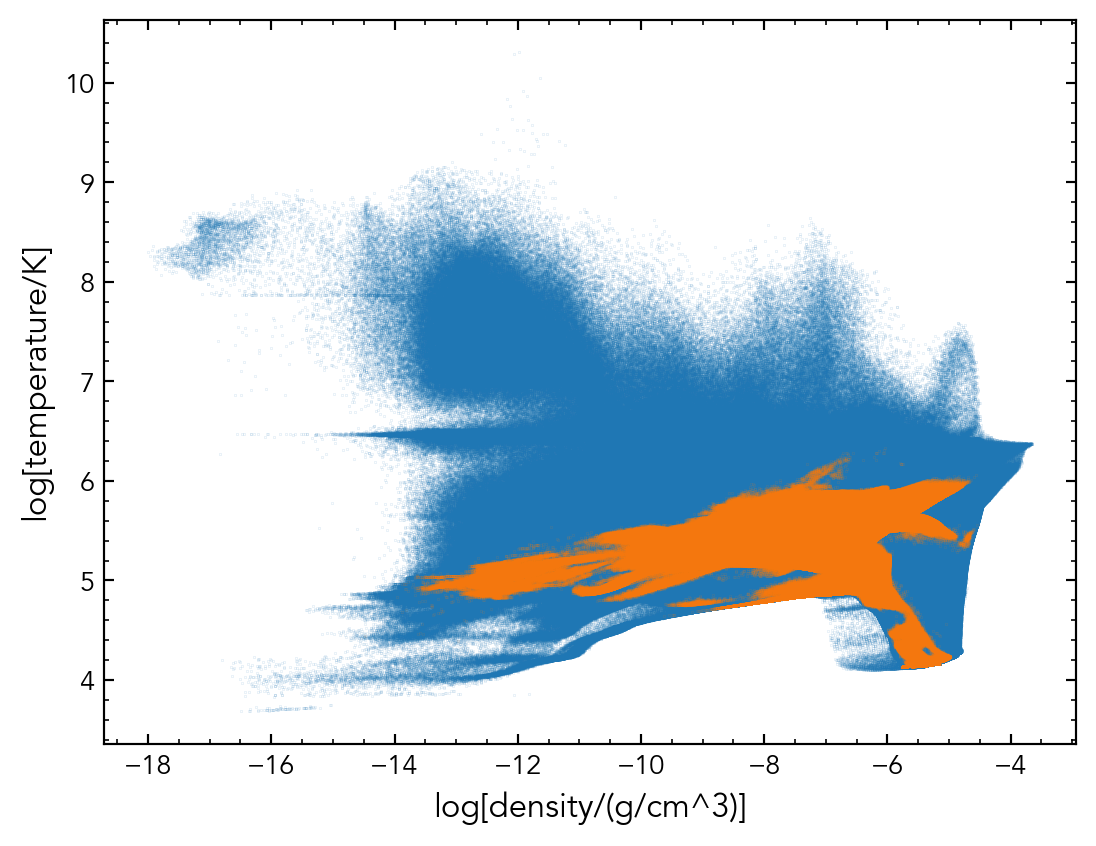

In [15]:
plt.scatter(np.log10(snap.density[star_mask][~mask].in_cgs()), np.log10(snap.temperature[star_mask][~mask].in_cgs()), s=0.001)
plt.scatter(np.log10(snap.density[star_mask][mask].in_cgs()), np.log10(snap.temperature[star_mask][mask].in_cgs()), s=0.001)
plt.xlabel('log[density/(g/cm^3)]')
plt.ylabel('log[temperature/K]')
plt.show()